In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [5]:
engine = create_engine("sqlite:///../data/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [10]:
inspector = inspect(engine)
inspector.get_table_names()

#find column names for measurement
columns = inspector.get_columns('Measurement')
for c in columns:
    print(c['name'],c['type'])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [11]:
#find column names for station
columns = inspector.get_columns('Station')
for c in columns:
    print(c['name'],c['type'])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [12]:
#look at data
engine.execute("Select * from Measurement order by date desc limit 5 ").fetchall()


[(2724, 'USC00519397', '2017-08-23', 0.0, 81.0),
 (7635, 'USC00514830', '2017-08-23', 0.0, 82.0),
 (12187, 'USC00519523', '2017-08-23', 0.08, 82.0),
 (19550, 'USC00516128', '2017-08-23', 0.45, 76.0),
 (2723, 'USC00519397', '2017-08-22', 0.0, 82.0)]

In [13]:
# Calculate the date 1 year ago from the last data point in the database
#last date in dataset 2017-08-23
last_date = session.query(Measurement.date).\
           filter(func.strftime(Measurement.date)).\
              order_by(Measurement.date.desc()).first()

vac=last_date[0].split('-')
last_year = dt.date(int(vac[0]),int(vac[1]),int(vac[2]))-dt.timedelta(days = 365)
last_year

datetime.date(2016, 8, 23)

In [14]:
#query last 12 mo of precipitation data
session.query(func.count(Measurement.date)).all()

prcp = session.query(Measurement.date, Measurement.prcp).\
            filter(Measurement.date > last_year).\
              order_by(Measurement.date).all()
prcp[0]

('2016-08-24', 0.08)

# Exploratory Climate Analysis

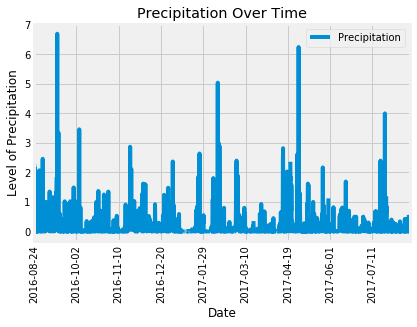

In [15]:
# Save the query results as a Pandas DataFrame and set the index to the date column
# Sort the dataframe by date
#converting into a DF to plot
df = pd.DataFrame.from_records(prcp,columns = ['Date', 'Precipitation'])
df.set_index('Date',inplace = True)

# Use Pandas Plotting with Matplotlib to plot the data
df.plot()
plt.xlabel('Date')
plt.ylabel('Level of Precipitation')
plt.title('Precipitation Over Time')
plt.xticks(rotation = 90)
plt.show()

In [16]:
# Use Pandas to calcualte the summary statistics for the precipitation data
df.describe()

,Precipitation
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [17]:
# Design a query to show how many stations are available in this dataset?
session.query(func.count(Station.station)).all()

[(9)]

In [18]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
top = session.query(Measurement.station,func.count(Measurement.station)).group_by(Measurement.station)\
                                .order_by(func.count(Measurement.station).desc()).first()
top

('USC00519281', 2772)

In [19]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
session.query(Measurement.station, func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
                filter(Measurement.station == top[0]).all()
            

[('USC00519281', 54.0, 85.0, 71.66378066378067)]

In [56]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

most_tobs = session.query(Measurement.station, func.count(Measurement.tobs).label('Count_tobs')).group_by(Measurement.station).\
                filter(Measurement.date > last_year).\
                order_by(func.count(Measurement.tobs).desc()).all()

df1 = pd.DataFrame.from_records(top1, columns = ['station','Count of Tobs'])
df1

,station,Count of Tobs
0,USC00519397,360
1,USC00519281,351
2,USC00516128,348
3,USC00513117,342
4,USC00519523,336
5,USC00514830,304
6,USC00517948,182


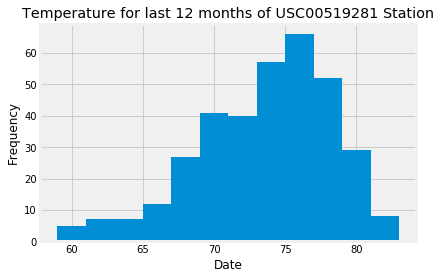

In [96]:
tobs_397 = session.query(Measurement.date, Measurement.tobs).\
                filter(Measurement.date > last_year).\
                filter(Measurement.station == 'USC00519281').all()

df2 = pd.DataFrame.from_records(tobs_397, columns = ['Date','Tobs'])
df2.set_index('Date',inplace = True)
df2
# # # Use Pandas Plotting with Matplotlib to plot the data

hist = df2.hist(bins = 12)
plt.xlabel('Date')
plt.ylabel('Frequency')
plt.title('Temperature for last 12 months of USC00519281 Station')
plt.show()

![precipitation](Images/station-histogram.png)

In [97]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()


print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [ ]:
calc_temps.plot()
plt.xlabel('Date')
plt.ylabel('Level of Precipitation')
plt.title('Precipitation Over Time')
plt.xticks(rotation = 90)
plt.show()

In [293]:
last_date = ['2017-01-07']

#creating start date in correct format
start_date=last_date[0].split('-')
start_date = dt.date(int(start_date[0]),int(start_date[1]),int(start_date[2]))-dt.timedelta(days = 6)

#creating end date in correct format
end_date = last_date[0].split('-')
end_date = dt.date(int(end_date[0]),int(end_date[1]),int(end_date[2]))
start_date


datetime.date(2017, 1, 1)

In [294]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps(start_date, end_date))
calc_temps

[(62.0, 68.36585365853658, 74.0)]


<function __main__.calc_temps(start_date, end_date)>

Text(0, 0.5, 'Temp (F)')

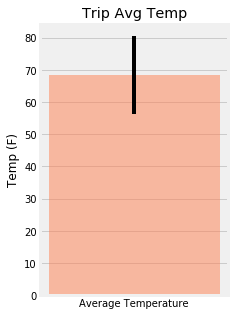

In [322]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


df_calc = pd.DataFrame.from_records(calc_temps(start_date, end_date), columns = ['tmin','tavg','tmax'])

x = 'Average Temperature'
y = df_calc['tavg']
error = df_calc['tmax'] - df_calc['tmin']

ax = df_calc.plot
plt.figure(figsize = (3,5))

plt.bar(x, y, yerr = error, color = 'coral', alpha = .5)
plt.grid(which='major', axis='x', linestyle='')
plt.grid(which='major', axis='y', linestyle='-')

plt.title('Trip Avg Temp')
plt.ylabel('Temp (F)')



In [325]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

merge = engine.execute('select a.station, b.name ,b.latitude, b.longitude, b.elevation, sum(a.prcp) from Measurement as a join Station as b on a.station = b.station where a.date >= "2017-01-01" and a.date <= "2017-01-07" group by a.station order by sum(a.prcp) desc ;').fetchall()
merge


[('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5, 0.61),
 ('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4, 0.6),
 ('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0, 0.6),
 ('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 0.35),
 ('USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9, 0.2),
 ('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.0)]

In [326]:
#turning the sql query into a dataframe
df3 = pd.DataFrame.from_records(merge, columns = ['Station','Name','Latitude','Longitude','Elevation','Sum of Precipitation'])
df3

,Station,Name,Latitude,Longitude,Elevation,Sum of Precipitation
0,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5,0.61
1,USC00516128,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4,0.60
2,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0,0.60
3,USC00513117,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6,0.35
4,USC00519281,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9,0.20
5,USC00519397,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0,0.00


## Optional Challenge Assignment

In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
